In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/opt/anaconda3/lib/python3.12/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


In [2]:
# Data Collection
ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.876106,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.167618,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.742676,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.400551,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.565201,132079200


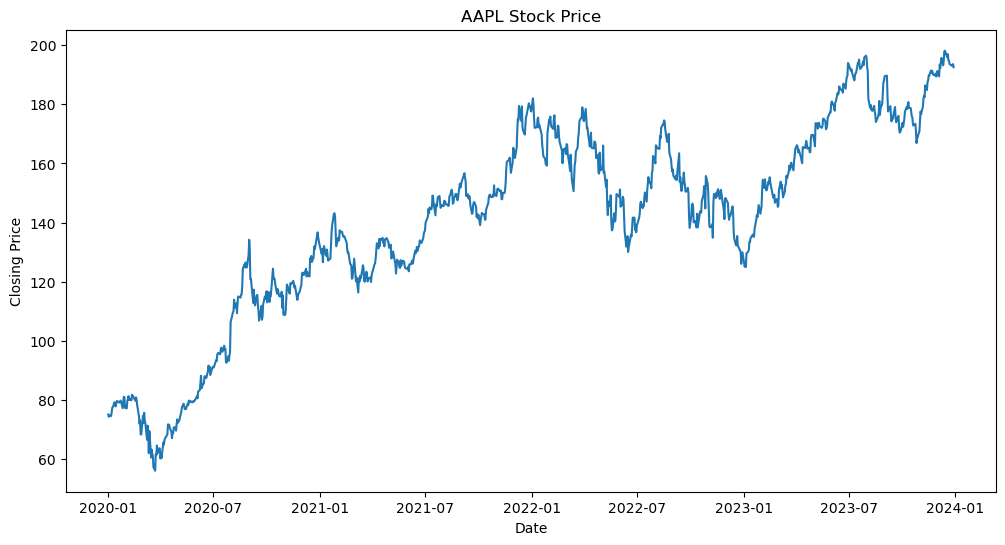

In [3]:
# Visualize Data
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'])
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [4]:
# Data Preprocessing
# Feature Selection
data = stock_data[['Close']]

# Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Splitting Data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [5]:
# Prepare Data for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape data to fit LSTM input requirements
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
# Define the Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
model.fit(X_train, y_train, batch_size=1, epochs=1)

 

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


743/743 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0134


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


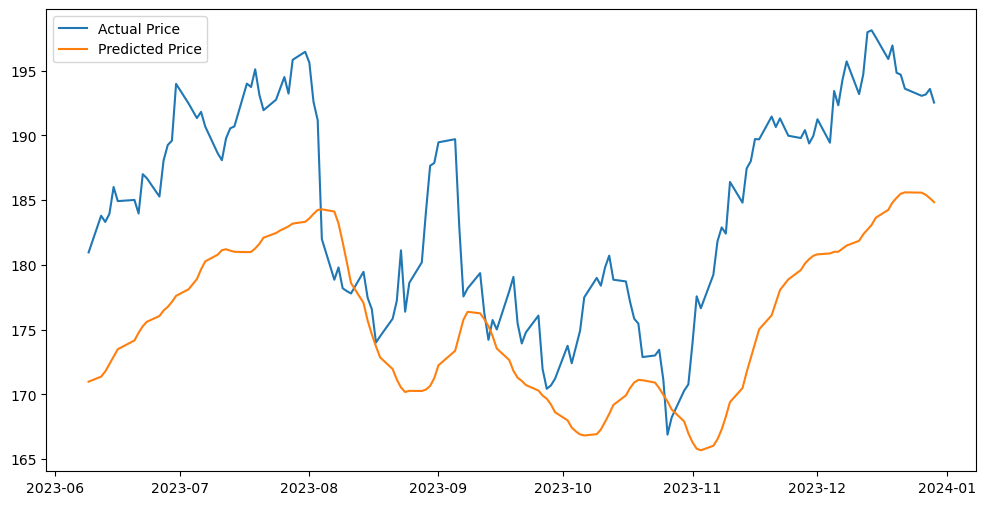

In [7]:
# Make Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Adjust the Test Data for Plotting
adjusted_test_data = test_data[time_step + 1:]
adjusted_test_data = scaler.inverse_transform(adjusted_test_data)

# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + time_step + 1:], adjusted_test_data, label='Actual Price')
plt.plot(data.index[train_size + time_step + 1:], predictions, label='Predicted Price')
plt.legend()
plt.show()

In [8]:
rmse = np.sqrt(mean_squared_error(adjusted_test_data, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 10.0691231940139


In [9]:
# Setup Backtesting Environment
class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()

# Apple data from yfinance
data = yf.download('AAPL', start='2015-01-01', end='2019-01-01')
bt = Backtest(data, SmaCross, commission=.002, exclusive_orders=True)
stats = bt.run()

# Plotting Results
bt.plot(filename='backtest_results.html', open_browser=True)

[*********************100%%**********************]  1 of 1 completed
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')
/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/anaconda3/lib/python3.12/site-packages/b

GridPlot(id='p1325', ...)

In [10]:

# Define Buy/Sell Signals and Backtesting Analysis

def generate_signals(predictions, threshold=0.02):
    buy_signals, sell_signals = [], []
    for i in range(1, len(predictions)):
        if predictions[i] > predictions[i-1] * (1 + threshold):
            buy_signals.append((i, predictions[i]))
        elif predictions[i] < predictions[i-1] * (1 - threshold):
            sell_signals.append((i, predictions[i]))
    return buy_signals, sell_signals

# Function to calculate Profit and Loss based on Buy/Sell Signals
def backtest_strategy(data, buy_signals, sell_signals):
    initial_cash = 10000  # Initial investment
    shares = 0
    cash = initial_cash

    for signal in buy_signals:
        # Buy shares at buy signal price
        cash -= data[signal[0]]
        shares += 1

    for signal in sell_signals:
        # Sell shares at sell signal price
        cash += data[signal[0]]
        shares -= 1

    # Calculate final value
    final_value = cash + (shares * data[-1])
    profit = final_value - initial_cash

    return profit

# Apply Buy/Sell Strategy based on LSTM predictions
predictions = model.predict(X_test)
buy_signals, sell_signals = generate_signals(predictions)
profit = backtest_strategy(scaled_data[-len(predictions):, 0], buy_signals, sell_signals)
print(f"Profit from strategy: ${profit:.2f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Profit from strategy: $0.00


In [ ]:
# Simulated Environment for Training

def simulate_trading_environment(data, model, threshold=0.02):
    initial_cash = 10000  # Starting amount in dollars
    shares = 0
    cash = initial_cash

    for i in range(len(data) - 1):
        # Predict future price
        current_price = data[i][0]  # Extract the value from ndarray
        future_price = model.predict(data[i].reshape(1, -1, 1))[0][0]  # Extract the value from prediction

        # Generate trading decision based on future prediction
        if future_price > current_price * (1 + threshold):
            # Buy signal
            cash -= current_price
            shares += 1
            print(f"Buying at price {current_price:.2f}")
        
        elif future_price < current_price * (1 - threshold):
            # Sell signal
            if shares > 0:
                cash += current_price
                shares -= 1
                print(f"Selling at price {current_price:.2f}")

    # Calculate the final value of cash and shares
    final_value = cash + (shares * data[-1][0])
    return final_value

# Running Simulated Trading Environment
final_value = simulate_trading_environment(scaled_data, model)
print(f"Final portfolio value: ${final_value:.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
# Stop-Loss and Take-Profit Mechanism

def trading_strategy_with_stop_loss(data, model, stop_loss_percent=0.05, take_profit_percent=0.10):
    initial_cash = 10000  # Starting cash amount in dollars
    shares = 0
    cash = initial_cash
    buy_price = 0

    for i in range(len(data) - 1):
        # Predict future price
        current_price = data[i][0]  # Extract the value from ndarray
        future_price = model.predict(data[i].reshape(1, -1, 1))[0][0]  # Extract the value from prediction

        if future_price > current_price * (1 + take_profit_percent):
            # Buy signal
            cash -= current_price
            shares += 1
            buy_price = current_price
            print(f"Buying at price {current_price:.2f}")

        # Stop-loss condition
        if shares > 0 and current_price < buy_price * (1 - stop_loss_percent):
            # Sell all shares to prevent loss
            cash += current_price
            shares = 0
            print(f"Stop-loss triggered. Selling at price {current_price:.2f}")

    # Calculate final portfolio value
    final_value = cash + (shares * data[-1][0])
    return final_value

# Execute Trading Strategy with Stop-Loss and Take-Profit
final_value_with_stop_loss = trading_strategy_with_stop_loss(scaled_data, model)
print(f"Final portfolio value with stop-loss: ${final_value_with_stop_loss:.2f}")


